# Титаник
В этом задании предлагается решить задачу предсказания выживших пассажиров Титаника. Информация о датасете доступна по <a href=https://www.kaggle.com/c/titanic.>ссылке</a>.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка данных

Загрузим датасет Titanic из приложенных файлов. В первом файле находится информация о пассажирах, во втором - информация о том, выжил пассажир или нет.


In [2]:
data = pd.read_csv('titanic_data.csv', index_col='PassengerId')
basic_features = data.columns

y = pd.read_csv('titanic_surv.csv')
y.index = data.index

print(f'Всего {len(data)} пассажиров в выборке')

data = data.join(y)
data.head()

Всего 891 пассажиров в выборке


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


## Исследование датасета

### Поиск корреляций признаков

In [3]:
data.corrwith(data["Survived"]).drop("Survived")

Pclass   -0.338481
Age      -0.077221
SibSp    -0.035322
Parch     0.081629
Fare      0.257307
dtype: float64

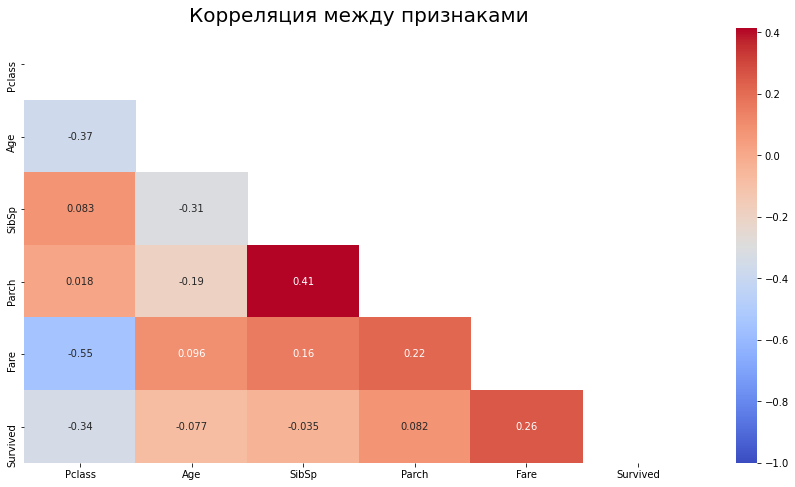

In [4]:
import seaborn as sns
plt.subplots(figsize = (15,8))
matrix = np.triu(data[["Pclass", "Age", "SibSp", "Parch", "Fare", "Survived"]].corr())
sns.heatmap(data[["Pclass", "Age", "SibSp", "Parch", "Fare", "Survived"]].corr(), annot
=True,cmap="coolwarm", vmin=-1.0, mask=matrix)
plt.title("Корреляция между признаками", fontsize = 20);

Большинство женщин выжило, большинство мужчин - нет:

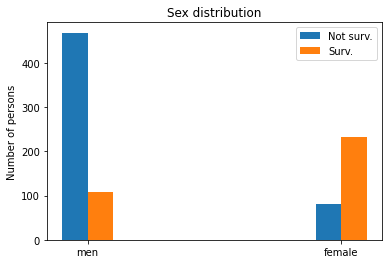

In [5]:
surv_sex_stats = data[['Sex','Survived']]

x = np.arange(2) 
surv = surv_sex_stats.loc[surv_sex_stats['Survived'] == 1].dropna()
not_surv = surv_sex_stats.loc[surv_sex_stats['Survived'] == 0].dropna()

not_surv = [not_surv.loc[not_surv['Sex'] == 'male'].count()[0], not_surv.loc[not_surv['Sex'] == 'female'].count()[0]]
surv = [surv.loc[surv['Sex'] == 'male'].count()[0], surv.loc[surv['Sex'] == 'female'].count()[0]]


plt.figure(1)
plt.bar(x-0.05, not_surv, 0.1) 
plt.bar(x+0.05, surv, 0.1)
plt.xticks(np.arange(2), ('men', 'female'))
plt.legend(['Not surv.', 'Surv.'])
plt.ylabel('Number of persons')
plt.title('Sex distribution')
print('')

Дети до 15-16 лет имеют больше шансов выжить, чем взрослые люди:

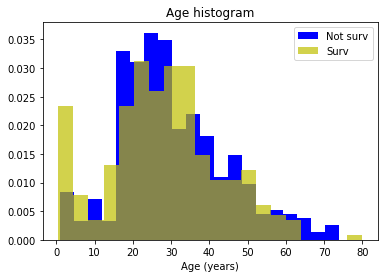

In [6]:
surv_age_stats = data[['Age','Survived']]
not_surv = surv_age_stats.loc[surv_age_stats['Survived'] == 0]['Age'].dropna()
surv = surv_age_stats.loc[surv_age_stats['Survived'] == 1]['Age'].dropna()

plt.figure(2)
n, bins, patches = plt.hist(not_surv, 20, density=True, facecolor='b')
n, bins, patches = plt.hist(surv, 20, density=True, facecolor='y', alpha=0.7)
plt.legend(['Not surv', 'Surv'])
plt.xlabel('Age (years)')
plt.title('Age histogram')

print('')

Большая часть пассажиров первого и второго класса выжили:

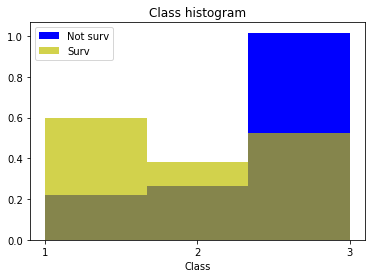

In [7]:
surv_class_stats = data[['Pclass','Survived']]
x = np.arange(3)
not_surv = surv_class_stats.loc[surv_class_stats['Survived'] == 0]['Pclass'].dropna()
surv     = surv_class_stats.loc[surv_class_stats['Survived'] == 1]['Pclass'].dropna()

plt.figure(3)
n, bins, patches = plt.hist(not_surv, 3, density=True, facecolor='b')
n, bins, patches = plt.hist(surv, 3, density=True, facecolor='y', alpha=0.7)
plt.xticks(np.arange(1,4))
plt.legend(['Not surv', 'Surv'])
plt.xlabel('Class')
plt.title('Class histogram')
print('')

У пассажиров, у которых стоимость билета превышает 10 долларов, выше шанс выжить:

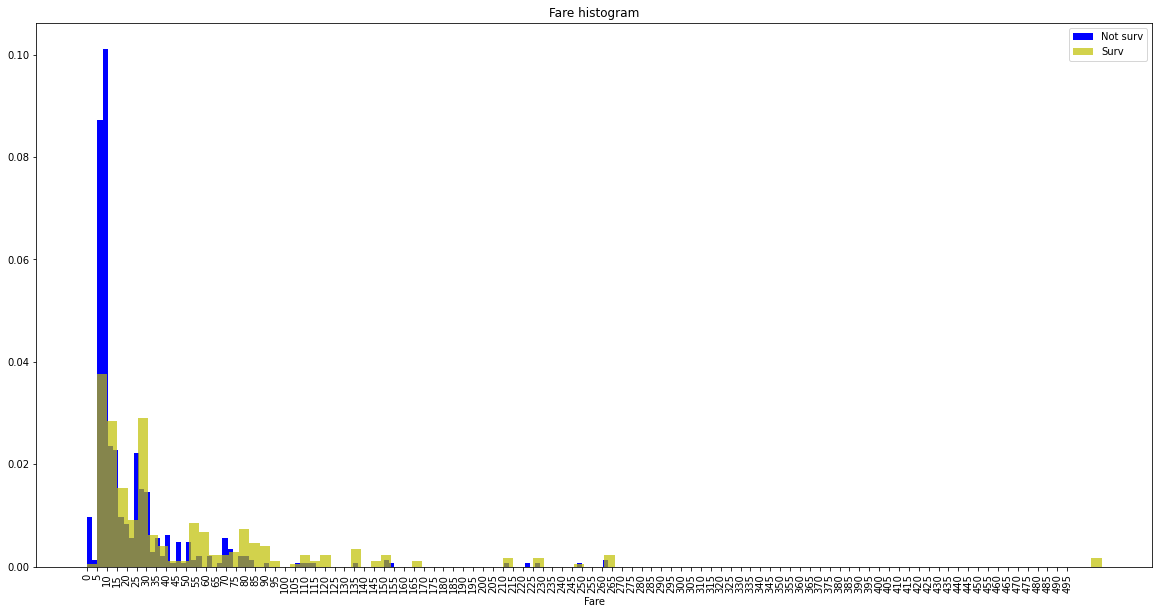

In [8]:
surv_age_stats = data[['Fare','Survived']]
not_surv = surv_age_stats.loc[surv_age_stats['Survived'] == 0]['Fare'].dropna()
surv = surv_age_stats.loc[surv_age_stats['Survived'] == 1]['Fare'].dropna()


plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(not_surv, 100, density=True, facecolor='b')
n, bins, patches = plt.hist(surv, 100, density=True, facecolor='y', alpha=0.7)
plt.legend(['Not surv', 'Surv'])
plt.xlabel('Fare')
plt.title('Fare histogram')
plt.xticks(np.arange(0, 500, step=5), rotation=90)

print('')

## Заполнение пропусков в данных
В данных имеются пропуски в трёх колонках: 

In [9]:
data.columns[data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Для простоты заполним все пропуски в категориальных колонках новым классом "0", а в числовой колонке Age --- медианным значением. 

In [10]:
data.loc[:, ['Cabin', 'Embarked']] = data.loc[:, ['Cabin', 'Embarked']].fillna('0')
data['Age'] = data['Age'].fillna(data['Age'].median())

## Выделение новых признаков

### Кодирование категориальных признаков и обработка данных
Все признаки сейчас делятся на числовые, бинарные, категориальные и текстовые. К текстовым признакам можно отнести имя пассажира, номер билета и номер каюты: значения этих признаков уникальны почти для всех пассажиров, и простого способа использовать их в модели не существует.

Создаём базовую версию признаков, с которой будем сравнивать их модификации

In [11]:
data_baseline = data.copy()

In [12]:
def get_class_category(row, category):
    if row['Pclass'] == 1 and category == 'class_1':
        return 1
    
    elif row['Pclass'] == 2 and category == 'class_2':
        return 1
    
    elif row['Pclass'] == 3 and category == 'class_3':
        return 1
    return 0


data_baseline['class_1'] = data_baseline.apply(get_class_category, axis=1, category='class_1')
data_baseline['class_2'] = data_baseline.apply(get_class_category, axis=1, category='class_2')
data_baseline['class_3'] = data_baseline.apply(get_class_category, axis=1, category='class_3')

In [13]:
categorical_indices = np.array([2]) # 0 - 'PClass', 2 - 'Sex', 8 - 'Cabin'
categorial_data = data_baseline[data_baseline.columns[categorical_indices]]
dummy_features = pd.get_dummies(categorial_data)

for col in categorial_data:
    del data_baseline[col]
    
del data_baseline['Pclass']
data_baseline = data_baseline.join(dummy_features)
# print(dummy_features)

In [14]:
def get_age_category(row, category):
    if row['Age'] <= 15 and category == 'age_child':
        return 1
    
    elif 15 < row['Age'] and category == 'age_adult':
        return 1
    return 0


data_baseline['age_child'] = data_baseline.apply(get_age_category, axis=1, category='age_child')
data_baseline['age_adult'] = data_baseline.apply(get_age_category, axis=1, category='age_adult')
del data_baseline['Age']

In [15]:
data_baseline['family'] = data_baseline['SibSp'] + data_baseline['Parch']
del data_baseline['SibSp']
del data_baseline['Parch']

In [16]:
del data_baseline['Name']
del data_baseline['Ticket']
del data_baseline['Cabin']
del data_baseline['Embarked']

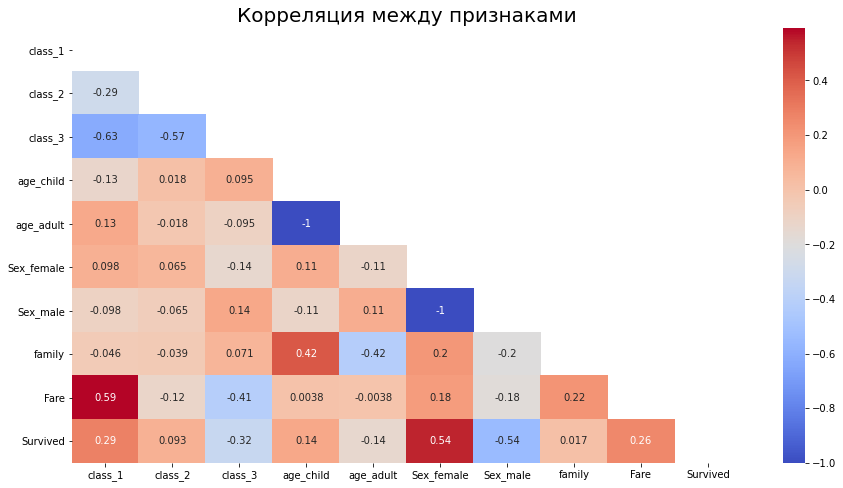

In [17]:
plt.subplots(figsize = (15,8))
matrix = np.triu(data_baseline.corr())
sns.heatmap(data_baseline[["class_1", "class_2", "class_3", "age_child", "age_adult", "Sex_female", "Sex_male", "family", "Fare", "Survived"]].corr(), annot=True, cmap='coolwarm', vmin=-1.0, mask=matrix)
plt.title("Корреляция между признаками", fontsize = 20);

## Линейная регрессия

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split



Train MSE: 0.14055486915733062
Test MSE: 0.14824509113301487
Train MAE: 0.28807532491140764
Test MAE: 0.2922623015577915
Train roc-auc: 0.8525537634408602
Test roc-auc: 0.8561768101599867


<Figure size 432x288 with 0 Axes>

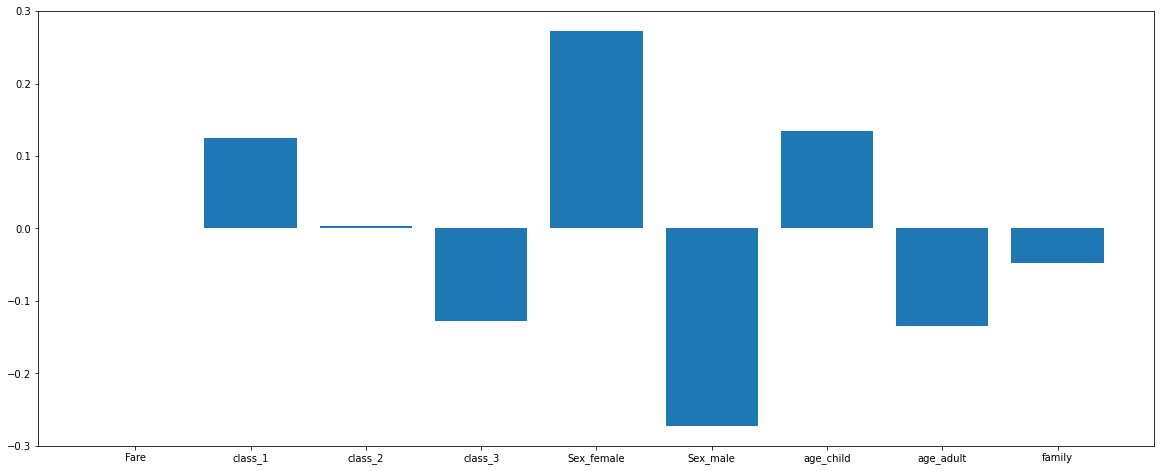

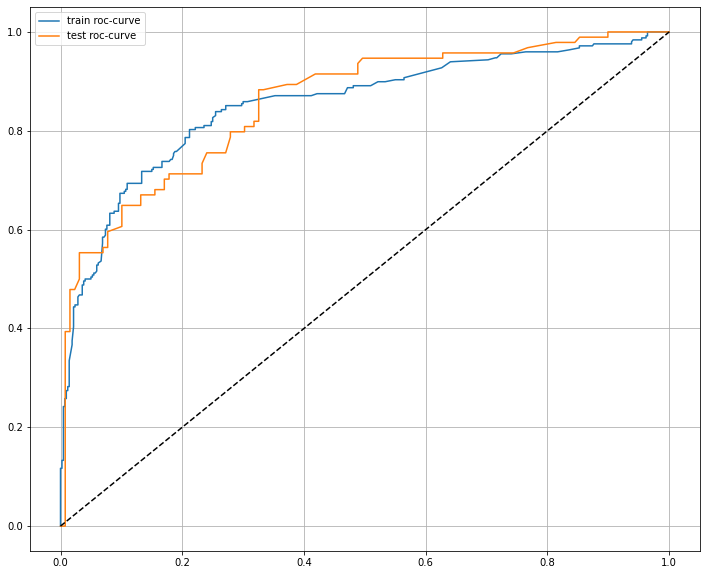



Кросс-валидация:

average_precision: Среднее MAE равно 0.813780789141292, стандартное отклонение MAE равно 0.03836166526023976

roc_auc: Среднее MAE равно 0.8517550650800152, стандартное отклонение MAE равно 0.020875930504208117


In [19]:
data_train, data_test = train_test_split(data_baseline)

X_train = data_train.drop(['Survived'], axis=1)
Y_train = data_train['Survived']

X_test = data_test.drop(['Survived'], axis=1)
Y_test = data_test['Survived']


X = data_baseline.drop(['Survived'], axis=1)
Y = data_baseline['Survived']


# X.info()
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test  = scaler.fit_transform(X_test)


model = LinearRegression()

model.fit(X_train, Y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

plt.figure(3)
plt.figure(figsize=(20, 8))
plt.bar(X_train.columns, model.coef_)




print(f'\n\nTrain MSE: {mean_squared_error(Y_train, y_train_prediction)}')
print(f'Test MSE: {mean_squared_error(Y_test, y_test_prediction)}')

print(f'Train MAE: {mean_absolute_error(Y_train, y_train_prediction)}')
print(f'Test MAE: {mean_absolute_error(Y_test, y_test_prediction)}')
y.mean()

roc_baseline = roc_auc_score(Y_test, y_test_prediction)
print(f'Train roc-auc: {roc_auc_score(Y_train, y_train_prediction)}')
print(f'Test roc-auc: {roc_baseline}')

plt.figure(4)
plt.figure(figsize=(12,10))
plt.plot(*roc_curve(Y_train, y_train_prediction)[:2], label='train roc-curve')
plt.plot(*roc_curve(Y_test, y_test_prediction)[:2], label='test roc-curve')
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.grid(True)
plt.legend()
plt.show()
    
# Кросс-валидация
result = cross_val_score(estimator=LinearRegression(), X=X, y=Y, scoring='average_precision', cv=5)
print('\n\nКросс-валидация:')
print(f'\naverage_precision: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
precision_linear = result.mean()

result = cross_val_score(estimator=LinearRegression(), X=X, y=Y, scoring='roc_auc', cv=5)
print(f'\nroc_auc: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
roc_auc_linear = result.mean()

## Логистическая регрессия

In [20]:
from sklearn.linear_model import LogisticRegression

Train roc-auc: 0.855213133640553
Test roc-auc: 0.8554346033316839


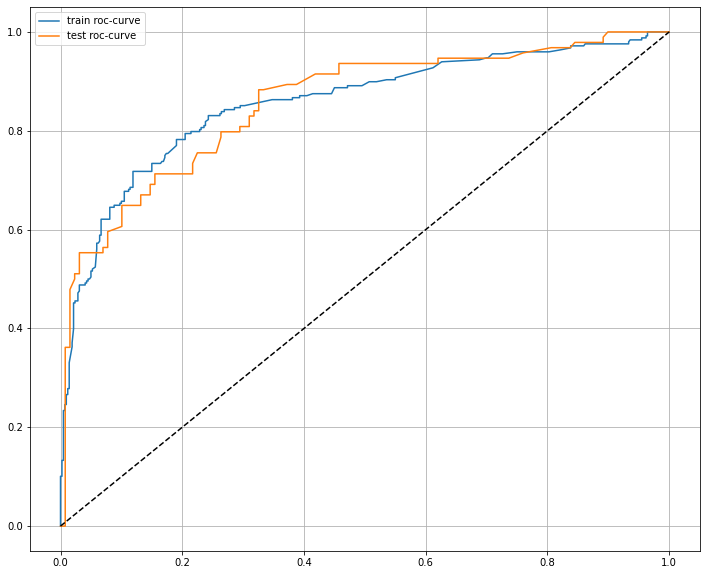



Кросс-валидация:

average_precision: Среднее MAE равно 0.8184780689515299, стандартное отклонение MAE равно 0.03168667556853654

roc_auc: Среднее MAE равно 0.8542165021718156, стандартное отклонение MAE равно 0.01747380196601287


In [21]:
model = LogisticRegression(max_iter=1000).fit(X_train, Y_train)

Y_train_proba = model.predict_proba(X_train)[:, 1]
Y_test_proba = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(12,10))


roc_logistic_regression = roc_auc_score(Y_test, Y_test_proba)
print(f'Train roc-auc: {roc_auc_score(Y_train, Y_train_proba)}')
print(f'Test roc-auc: {roc_logistic_regression}')



plt.plot(*roc_curve(Y_train, Y_train_proba)[:2], label='train roc-curve')
plt.plot(*roc_curve(Y_test, Y_test_proba)[:2], label='test roc-curve')

plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.grid(True)
plt.legend()
plt.show()

# Кросс-валидация
result = cross_val_score(estimator=LogisticRegression(max_iter=1000), X=X, y=Y, scoring='average_precision', cv=5)
print('\n\nКросс-валидация:')
print(f'\naverage_precision: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
precision_logistic = result.mean()

result = cross_val_score(estimator=LogisticRegression(max_iter=1000), X=X, y=Y, scoring='roc_auc', cv=5)
print(f'\nroc_auc: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
roc_auc_logistic = result.mean()

### KNN и Решающее дерево
Функция поиска оптимального гиперпараметра

In [22]:
def plot_roc_curve(model, X_train, X_test, y_train, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=(12,10))
    
    roc = roc_auc_score(y_test, y_test_proba)
    print(f'Train roc-auc: {roc_auc_score(y_train, y_train_proba)}')
    print(f'Test roc-auc: {roc}')


    plt.plot(*roc_curve(y_train, y_train_proba)[:2], label='train roc-curve')
    plt.plot(*roc_curve(y_test, y_test_proba)[:2], label='test roc-curve')

    plt.plot([0,1], [0,1], linestyle='--', color='black')
    plt.grid(True)
    plt.legend()
    plt.show()
    return roc

In [23]:
from sklearn.model_selection import GridSearchCV

def search(X, y, model, param_name, grid, draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=8)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        plt.plot(grid, means, label='mean values of score')

        plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green', label='deviation area between errors')
        plt.legend()
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

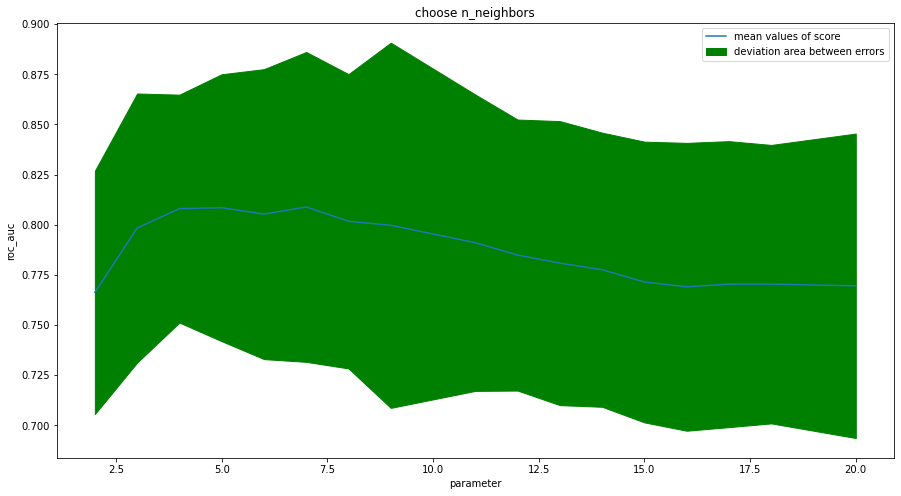

In [25]:
models = [KNeighborsClassifier(n_jobs=8)]
param_names = ['n_neighbors']
grids = [np.array(np.linspace(2, 20, 17), dtype='int')]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, Y_train, model, param_name, grid, param_scale)

В результате получаем, что оптимальным значением параметра n_neighbors примерно jявляется 4.

Проверяем результат:

Train roc-auc: 0.9053667434715821
Test roc-auc: 0.8447138380339766


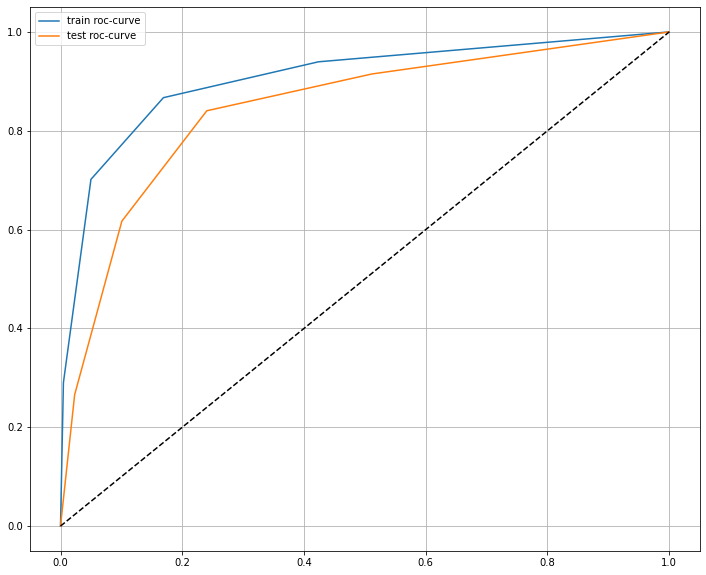



Кросс-валидация:

average_precision: Среднее MAE равно 0.6937313462982232, стандартное отклонение MAE равно 0.050755936053835424

roc_auc: Среднее MAE равно 0.820140593859475, стандартное отклонение MAE равно 0.04023057534072528


In [26]:
model = KNeighborsClassifier(n_neighbors=4, n_jobs=8).fit(X_train, Y_train)
roc_knn = plot_roc_curve(model, X_train, X_test, Y_train, Y_test)

# Кросс-валидация
result = cross_val_score(estimator=KNeighborsClassifier(n_neighbors=4, n_jobs=8), X=X, y=Y, scoring='average_precision', cv=5)
print('\n\nКросс-валидация:')
print(f'\naverage_precision: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
precision_knn = result.mean()

result = cross_val_score(estimator=KNeighborsClassifier(n_neighbors=6, n_jobs=8), X=X, y=Y, scoring='roc_auc', cv=5)
print(f'\nroc_auc: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
roc_auc_knn = result.mean()

### Для дерева решений:

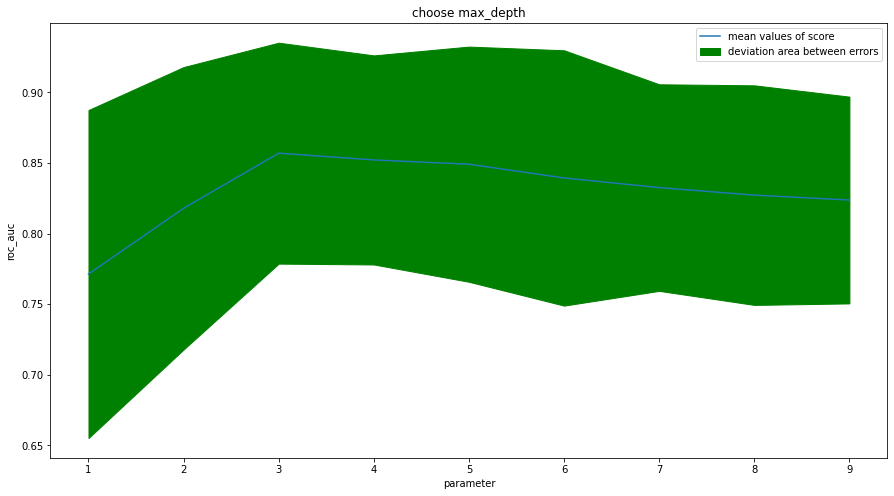

In [27]:
models = [DecisionTreeClassifier()]
param_names = ['max_depth']
grids = [np.arange(1, 10, 1)]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, Y_train, model, param_name, grid, param_scale) 

Train roc-auc: 0.8739439324116742
Test roc-auc: 0.861578426521524


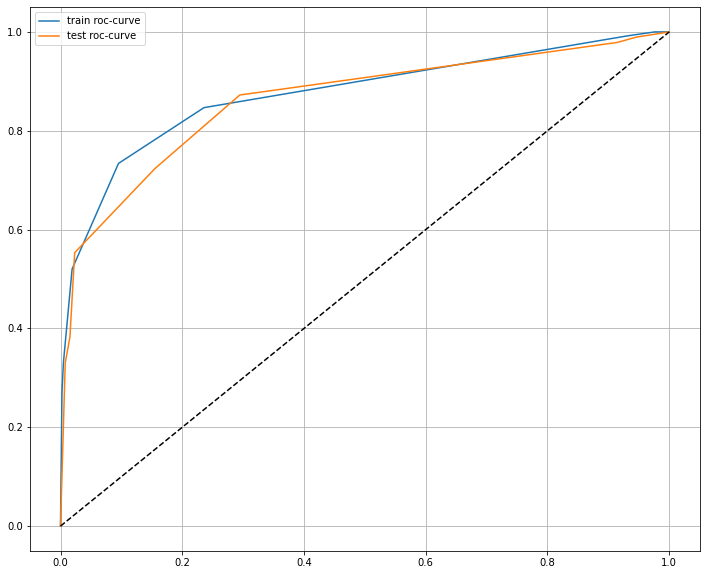



Кросс-валидация:

average_precision: Среднее MAE равно 0.801380226938676, стандартное отклонение MAE равно 0.02097843168831566

roc_auc: Среднее MAE равно 0.8622065027193022, стандартное отклонение MAE равно 0.020426382099208322


In [33]:
model = DecisionTreeClassifier(max_depth=3).fit(X_train, Y_train)
roc_tree = plot_roc_curve(model, X_train, X_test, Y_train, Y_test)

# Кросс-валидация
result = cross_val_score(estimator=DecisionTreeClassifier(max_depth=3), X=X, y=Y, scoring='average_precision', cv=5)
print('\n\nКросс-валидация:')
print(f'\naverage_precision: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
precision_tree = result.mean()

result = cross_val_score(estimator=DecisionTreeClassifier(max_depth=3), X=X, y=Y, scoring='roc_auc', cv=5)
print(f'\nroc_auc: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
roc_auc_tree = result.mean()

Итог: дерево решений даёт плохой результат для данной задачи

### Случайный лес

In [39]:
from sklearn.ensemble import RandomForestClassifier
models = [RandomForestClassifier(n_jobs=8)]
param_names = ['n_estimators']
grids = [np.array(np.linspace(2, 30, 28), dtype='int')]
param_scales = ['ordinary']

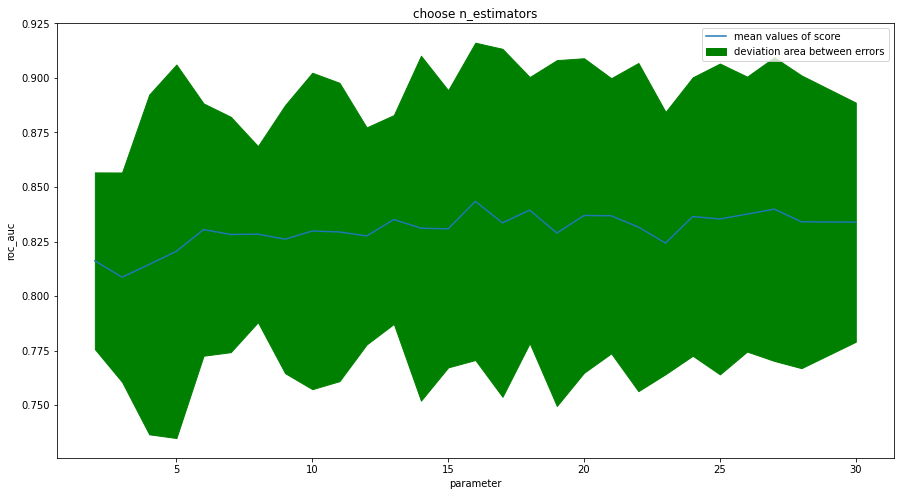

In [40]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, Y_train, model, param_name, grid, param_scale)

Судя по полученному графику, наиболее оптимальное значение параметра n_estimators - 6

Train roc-auc: 0.9738959293394778
Test roc-auc: 0.855104733630216


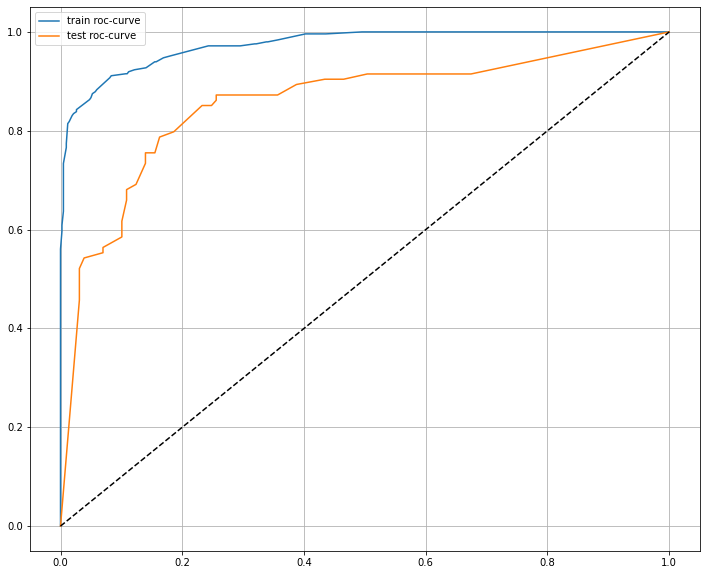



Кросс-валидация:

average_precision: Среднее MAE равно 0.8093351526042142, стандартное отклонение MAE равно 0.03589007827927869

roc_auc: Среднее MAE равно 0.8636664060772439, стандартное отклонение MAE равно 0.025987958259012133


In [42]:
model = RandomForestClassifier(n_estimators=6, n_jobs=8).fit(X_train, Y_train)
roc_rtree = plot_roc_curve(model, X_train, X_test, Y_train, Y_test)

# Кросс-валидация
result = cross_val_score(estimator=DecisionTreeClassifier(max_depth=6), X=X, y=Y, scoring='average_precision', cv=5)
print('\n\nКросс-валидация:')
print(f'\naverage_precision: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
precision_rtree = result.mean()

result = cross_val_score(estimator=DecisionTreeClassifier(max_depth=6), X=X, y=Y, scoring='roc_auc', cv=5)
print(f'\nroc_auc: Среднее MAE равно {result.mean()}, стандартное отклонение MAE равно {result.std()}')
roc_auc_rtree = result.mean()

## Результаты моделирования

Лучшими из опробованных методов по метрике roc-auc стали **случайный лес** и **дерево решений**

In [43]:
from IPython.display import display, Markdown, Latex
display(Markdown(f'''|  | precision | roc-auc |
| --- | --- | --- |
| Linear regression | {precision_linear} | {roc_auc_linear} |
| Logistic regression  | {precision_logistic} | {roc_auc_logistic} |
| KNN       | {precision_knn} | {roc_auc_knn} |
| Desicion tree | {precision_tree} | {roc_auc_tree} |
| Random forest | {precision_rtree} | {roc_auc_rtree} |
'''))

|  | precision | roc-auc |
| --- | --- | --- |
| Linear regression | 0.813780789141292 | 0.8517550650800152 |
| Logistic regression  | 0.8184780689515299 | 0.8542165021718156 |
| KNN       | 0.6937313462982232 | 0.820140593859475 |
| Desicion tree | 0.801380226938676 | 0.8622065027193022 |
| Random forest | 0.8093351526042142 | 0.8636664060772439 |
